This is a reusable notebook where you just change the value of a variable and it does the moving,
unzipping and returning of contents

In [0]:
fileroot =  "clinicaltrial_2021.csv" #Give exact file name here
Year = '2021'                        #Give Year also according to file i.e (2019, 2020, 2021)

Making the environment to extract the desired conclusions

In [0]:
#Renaming the files
#dbutils.fs.cp('/FileStore/tables/clinicaltrial_2019_csv.gz','/FileStore/tables/clinicaltrial_2019.csv.gz')
#dbutils.fs.cp('/FileStore/tables/clinicaltrial_2020_csv.gz','/FileStore/tables/clinicaltrial_2020.csv.gz')
dbutils.fs.cp('/FileStore/tables/clinicaltrial_2021_csv.gz','/FileStore/tables/clinicaltrial_2021.csv.gz')

Out[2]: True

In [0]:
#copying the file to /tmp directory and unzipping
dbutils.fs.cp("/FileStore/tables/" + fileroot + ".gz", "file:/tmp/")
import os
os.environ ['fileroot'] = fileroot

In [0]:
%sh gunzip -d /tmp/$fileroot.gz 

gzip: /tmp/clinicaltrial_2021.csv already exists;	not overwritten


In [0]:
#creating directory and moving file 
from pathlib import Path
Path("/FileStore/tables/" + fileroot).mkdir(parents=True, exist_ok=True)
#dbutils.fs.mkdirs ("/FileStore/tables/" + fileroot )
dbutils.fs.mv("file:/tmp/" + fileroot , "/FileStore/tables/" + fileroot , True )

Out[5]: True

Making the RDDs

In [0]:
RDD2021= sc.textFile('FileStore/tables/'+fileroot)
RDDmesh= sc.textFile('dbfs:/FileStore/tables/mesh.csv')
RDDpharma= sc.textFile('dbfs:/FileStore/tables/pharma.csv')

Question 1 : The number of studies in the dataset. You must ensure that you explicitly check distinct studies.

In [0]:
RDD2021_New = RDD2021
RDD2021_Header = RDD2021_New.first()
RDD2021_Count = RDD2021.filter(lambda Header: Header!=RDD2021_Header)  
RDD2021_Count.distinct().count()

Out[7]: 387261

Question 2:  You should list all the types (as contained in the Type column) of studies in the dataset along with
the frequencies of each type. These should be ordered from most frequent to least frequent.

In [0]:
RDD2021_Split=RDD2021.map(lambda Word:Word.split('|'))
RDD2021_Type=RDD2021_Split.map(lambda index: index[5])\
.map(lambda x:(x,1)).reduceByKey(lambda v1,v2:v1+v2).sortBy(lambda v:v[1],ascending =False)
RDD2021_Type.take(4)

Out[8]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

Question 3: The top 5 conditions (from Conditions) with their frequencies.

In [0]:
RDD2021_Disease1=RDD2021_Split.flatMap(lambda index: index[7].split(','))\
.filter(lambda c: c != '')
RDD2021_Disease=RDD2021_Disease1.map(lambda x:(x,1)).reduceByKey(lambda v1,v2:v1+v2).sortBy(lambda v:v[1],ascending =False)
RDD2021_Disease.take(5)

Out[9]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

Question 4:  Each condition can be mapped to one or more hierarchy codes. The client wishes to know the 5
most frequent roots (i.e. the sequence of letters and numbers before the first full stop) after this is
done.

In [0]:
RDDmesh_Header = RDDmesh.first()
RDDmesh_Header_Remove = RDDmesh.filter(lambda Header: Header!=RDDmesh_Header)
RDDmesh_Split = RDDmesh_Header_Remove.map(lambda x:(x.split(",")[0], x.split(",")[1].split(".")[0]))
#RDDmesh_Split.take(2)

In [0]:
RDD2021_Recount= RDD2021_Disease1.map(lambda x:[x,1])
RDD2021_DiseaseCode = RDD2021_Recount.join(RDDmesh_Split).map(lambda y: (y[1][1], 1))\
.reduceByKey(lambda v1, v2: v1+ v2).sortBy(lambda x: -x[1])    
RDD2021_DiseaseCode.take(10)

Out[11]: [('C04', 143994),
 ('C23', 136079),
 ('C01', 106674),
 ('C14', 94523),
 ('C10', 92310),
 ('C06', 85646),
 ('C08', 70720),
 ('C13', 42599),
 ('C18', 41276),
 ('C12', 40161)]

Question 5: Find the 10 most common sponsors that are not pharmaceutical companies, along with the number
of clinical trials they have sponsored. Hint: For a basic implementation, you can assume that the
Parent Company column contains all possible pharmaceutical companies.

In [0]:
RDD2021_Sponsor = RDD2021_Split.map(lambda s: s[1])\
.filter(lambda c: c != '')\
.map(lambda x: (x, 1))
RDDpharma_Split=RDDpharma.map(lambda x: x.replace('"','').split(',')[1])\
.map(lambda v: (v,1))
RDD2021_Joined = RDD2021_Sponsor.leftOuterJoin(RDDpharma_Split).filter(lambda x : x[1][1] == None)\
.map(lambda y: (y[0], 1))\
.reduceByKey(lambda v1, v2: v1+ v2).sortBy(lambda x: -x[1])
RDD2021_Joined.take(10)

Out[12]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

Question 6: Plot number of completed studies each month in a given year – for the submission dataset, the year
is 2021. You need to include your visualization as well as a table of all the values you have plotted
for each month.

In [0]:
RDD1 = RDD2021_Split.first()
RDD2021_Count = RDD2021_Split.filter(lambda Header: Header!=RDD1)
RDD2021_Study_Completion=RDD2021_Count.map(lambda x: (x[4].split(),x[2]))\
                                           .filter(lambda x: len(x[0])!=0)\
                                           .filter(lambda y:(y[1]=='Completed'))\
                                           .filter(lambda z: (z[0][1]==Year))\
                                           .map(lambda a: (a[0][0],1))\
                                           .reduceByKey(lambda v1, v2: v1+ v2)

#RDD2021_Study_Completion.take(12)

In [0]:
import calendar
Sorting = {a:z for z,a in enumerate(calendar.month_abbr[1:],1)}
RDD2021_Study_Completion_Sorting=RDD2021_Study_Completion.sortBy(lambda g: Sorting.get(g[0]))
RDD2021_Study_Completion_Sorting.collect()

Out[14]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

RDD Visualization

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Out[16]: <BarContainer object of 10 artists>

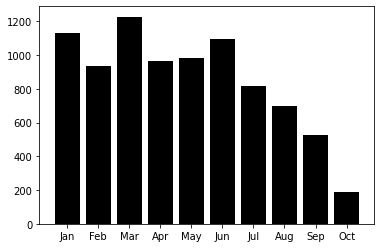

In [0]:
x=RDD2021_Study_Completion_Sorting.map(lambda x: (x[0])).collect()
y=RDD2021_Study_Completion_Sorting.map(lambda x: (x[1])).collect()
plt.bar(x,y, color='black')

Out[17]: <BarContainer object of 10 artists>

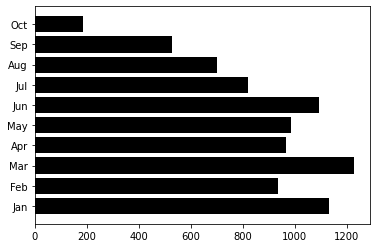

In [0]:
plt.barh(x,y, color='black')

Out[18]: [<matplotlib.lines.Line2D at 0x7fe6c84e90d0>]

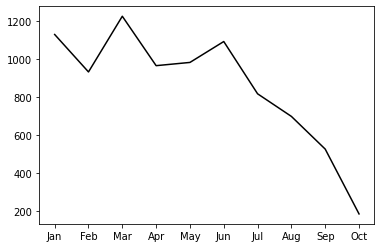

In [0]:
plt.plot(x,y, color='black')